In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re

import numpy as np
from skimage import io


def bbox_from_polygon(polygon):
    """ Convert a polygon to a bounding box.

    Args:
        polygon: tuple, polygon with coordinates and text

    Returns:
        tuple, bounding box with coordinates and text
    """
    coords = polygon[0]
    text = polygon[1]

    # Bounding box [x, y, w, h], where (x, y) is the top-left corner and w, h are the width and height
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    w = x_max - x_min
    h = y_max - y_min

    return (x_min, y_min, w, h), text


def decode_line_bbox(line):
    """ Decode a line with bounding box coordinates and text.

    Args:
        line: str, line with bounding box coordinates and text

    Returns:
        tuple, bounding box with coordinates and text
    """
    # Decode the bounding box and text from the line (negative values are clipped to 0)
    bbox = [max(0, int(x)) for x in line.split(",")[:-1]]
    text = line.split(",")[-1].strip()
    return bbox, text


def decode_line_polygon(line):
    """ Decode a line with polygon coordinates and text.

    Args:
        line: str, line with polygon coordinates and text

    Returns:
        tuple, polygon with coordinates and text
    """
    # Define the regex pattern
    pattern = r'\[([^\]]+)\], \[([^\]]+)\], (-?\d+), (-?\d+), (.+)'

    # Use regex to find matches
    match = re.match(pattern, line)

    if match:
        # Extract the lists, integers, and string from the match groups
        list1_str, list2_str, _, _, text = match.groups()

        # Convert the list strings to actual lists of integers (negative values are clipped to 0)
        list1 = [max(0, int(x)) for x in list1_str.split(', ')]
        list2 = [max(0, int(y)) for y in list2_str.split(', ')]

        # Create a polygon from the lists
        polygon = [(list1[i], list2[i]) for i in range(len(list1))]

        # Convert to clockwise order
        polygon = [polygon[0]] + polygon[1:][::-1]
        return polygon, text.strip()
    else:
        raise ValueError("The input line is not in the expected format.")


def extract_fields_from_file(fname, include_bbox_from_polygons=True):
    """ Extract bounding boxes and polygons from a file.

    Args:
        fname: str, full path to the file

    Returns:
        list, list of bounding boxes
        list, list of polygons
    """

    polygons = []
    bboxes = []
    with open(fname, "r", encoding="ISO-8859-1") as f:
        lines = f.readlines()
        for line in lines:
            if line[0] in "-0123456789":
                bbox = decode_line_bbox(line)
                bboxes.append(bbox)
            if line[0] == "[":
                polygon = decode_line_polygon(line)
                polygons.append(polygon)

    if include_bbox_from_polygons:
        for polygon in polygons:
            bboxes.append(bbox_from_polygon(polygon))

    return bboxes, polygons


def dump_fields_to_file(fname, bboxes, polygons):
    """ Dump bounding boxes and polygons to a file.

    Args:
        fname: str, full path to the file
        bboxes: list, list of bounding boxes
        polygons: list, list of polygons
    """

    # Templates for the lines
    bbox_line_template = "{x}, {y}, {w}, {h}, {text}"
    polygon_line_template = "{list1}, {list2}, -1, -1, {text}"

    # List of lines to be written to the file
    lines = []

    # Header
    lines.append("x1, y1, x2, y2, transcription")

    # Bounding boxes
    for bbox, text in bboxes:
        lines.append(bbox_line_template.format(x=bbox[0], y=bbox[1], w=bbox[2], h=bbox[3], text=text))

    # Polygons
    for polygon, text in polygons:
        # Convert to anti-clockwise order (for compatibility with the original format)
        polygon = [polygon[0]] + polygon[1:][::-1]
        list1 = [coord[0] for coord in polygon]
        list2 = [coord[1] for coord in polygon]
        lines.append(polygon_line_template.format(list1=str(list1), list2=str(list2), text=text))

    # Dump the content to the file
    with open(fname, "w") as f:
        f.write("\n".join(lines))


def detect_pose(img_path, face="front", keyword=None, return_bbox_kw=False):
    """ Detects the pose of a document image based on the annotation file.

    Args:
        img_path: str, path to the image
        face: str, face of the document (front, back)
        keyword: str, keyword to search for in the annotation file
        return_bbox_kw: bool, whether to return the bounding box of the keyword

    Returns:
        pose: str, pose of the document (normal, upside-down, left, right)
        bbox: list, bounding box of the keyword
    """

    # Map face to keyword
    if keyword is None:
        map_face_keyword = {
            "front": "nome",
            "back": "observações"
        }
        keyword = map_face_keyword[face]

    # Load document image as rgb 3-channel image
    img = io.imread(img_path)
    height_img, width_img, _ = img.shape

    # Load bboxes annotation from CNH OCR txt file and search for the bbox with the keyword
    fname_txt = img_path.replace("_in", "_gt_ocr").replace(".jpg", ".txt")

    # Extract fields from the annotation file (polygons and bboxes)
    bboxes, _ = extract_fields_from_file(fname_txt, include_bbox_from_polygons=True)

    # Search for the keyword in the bboxes
    bbox_kw = None
    for bbox in bboxes:
        text = bbox[1]
        # print(text.lower(), keyword)
        if text.lower() == keyword:
            bbox_kw = bbox
            break

    # Raise exception if keyword is not found
    if bbox_kw is None:
        print(f"Keyword {keyword} not found in {fname_txt}")
        raise ValueError("Keyword not found in the annotation file.")

    # Detect pose by analyzing the bbox position
    x, y = bbox_kw[0][:2]
    pose = "normal"
    # Check whether the aspect ratio
    if width_img > height_img:
        # Upside-down if bbox is below the center
        if y > height_img / 2:
            pose = "upside-down"
    else:
        # Left if bbox is on the left side and right if on the right side
        pose = "left" if x < width_img / 2 else "right"

    if return_bbox_kw:
        return pose, bbox_kw
    return pose


def rotate_image(img, pose):
    """ Rotates the image based on the pose.

    Args:
        img: np.array, image to be corrected
        pose: str, pose of the image

    Returns:
        rotated_img: np.array, rotated image
    """
    rotated_img = img.copy()
    if pose == "upside-down":
        rotated_img = np.rot90(rotated_img, 2)
    elif pose == "left":
        rotated_img = np.rot90(rotated_img, -1)
    elif pose == "right":
        rotated_img = np.rot90(rotated_img)

    return rotated_img

def rotate_fields_coordinates(bboxes, polygons, img_height, img_width, pose="Normal"):
    """ Rotate the coordinates of the bounding boxes and polygons.

    Args:
        bboxes: list, list of bounding boxes
        polygons: list, list of polygons
        img_height: int, height of the document image
        img_width: int, width of the document image
        pose: str, pose of the document (normal, upside-down, left, right)

    Returns:
        rotated_bboxes: list, list of rotated bounding boxes
        rotated_polygons: list, list of rotated polygons
    """

    if pose == "Normal":
        return bboxes, polygons
    else:
        rotated_bboxes = []
        for bbox, text in bboxes:
            x, y, w, h = bbox
            if pose == "upside-down":
                x = img_width - x - w
                y = img_height - y - h
            elif pose == "left":
                x, y = img_height - y - h, x
                w, h = h, w
            elif pose == "right":
                x, y = y, img_width - x - w
                w, h = h, w
            rotated_bboxes.append([(x, y, w, h), text])

        rotated_polygons = []
        for coords, text in polygons:
            rotated_coords = []
            for coord in coords:
                x, y = coord
                if pose == "upside-down":
                    x = img_width - x
                    y = img_height - y
                elif pose == "left":
                    x, y = img_height - y, x
                elif pose == "right":
                    x, y = y, img_width - x
                rotated_coords.append((x, y))
            rotated_polygons.append((rotated_coords, text))

    return rotated_bboxes, rotated_polygons


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('..')

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
PATH_FRONT = "/content/drive/MyDrive/Original/CNH_Frente"
PATH_BACK = "/content/drive/MyDrive/Original/CNH_Verso"
PATH_FRONT_PROCESSED = "/content/drive/MyDrive/processed/BID Dataset/CNH_Frente"
PATH_BACK_PROCESSED = "/content/drive/MyDrive/processed/BID Dataset/CNH_Verso"

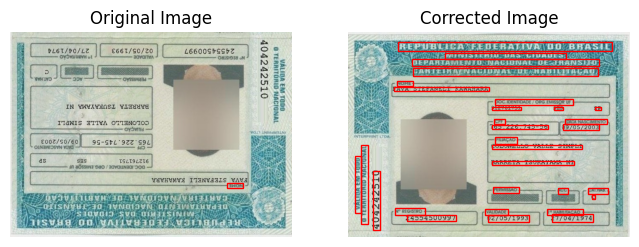

In [ ]:
fname = "00003604_in.jpg"
fname = os.path.join(PATH_FRONT, fname)
fname_txt = fname.replace("_in", "_gt_ocr").replace(".jpg", ".txt")

img = io.imread(fname)
pose, bbox = detect_pose(fname, face="front", return_bbox_kw=True)
img_corrected = rotate_image(img, pose)

fig, ax = plt.subplots(1, 2, figsize=(8, 16))
ax[0].imshow(img)
ax[1].imshow(img_corrected)
ax[0].axis("off")
ax[1].axis("off")

# Plot bbox_kw on ax[0]
(x, y, w, h), _ = bbox
ax[0].add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))
ax[0].set_title("Original Image")

# Extract fields from txt and correct the orientation
bboxes, polygons = extract_fields_from_file(fname_txt, include_bbox_from_polygons=False)
bboxes, polygons = rotate_fields_coordinates(bboxes, polygons, img.shape[0], img.shape[1], pose=pose)

for (x, y, w, h), text in bboxes:
    ax[1].add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))

for (polygon, text) in polygons:
    plt.gca().add_patch(plt.Polygon(polygon, linewidth=1, edgecolor="b", facecolor="none"))

ax[1].set_title("Corrected Image")
plt.show()